In [ ]:
import pandas as pd
import datetime
import numpy as np
import sklearn
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sn.set()

Read merged dataset

In [ ]:
df = pd.read_csv('botNoBot2018.csv',lineterminator='\n')
df.shape

(13276, 44)

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(26,20))

for i, c in enumerate(df.columns):
    if c =='category':
        continue
    ax = axes.reshape(-1)[i]
    if df[c].dtype.kind == 'O':
        ct = pd.crosstab(index=df[c], columns=df['category'],normalize='index')
        a = ct.plot(kind='bar', stacked=True,ax=ax)  
    else:
        b = sn.histplot(x=c,hue='category',data=df,multiple='stack',ax=ax)
    t = ax.set_title(c)
plt.tight_layout()

# Feature selection

In [ ]:
delCols = ["id", # Identifiers are not usefull
           "id_str", # Identifiers are not usefull
           "protected", # All false
           "name", # We can't use this information
           "screen_name", # We can't use this information
           "description", # We can't use this information
           "url", # We can't use this information
           "utc_offset", # Deprecated, many nulls
           "time_zone", # Deprecated, many nulls
           "location", # Almost everything unique
           "contributors_enabled", # All false
           "is_translator", # All false
           "is_translation_enabled", # Almost all false
           "profile_background_tile", # We don't know what is it
           "has_extended_profile", # We don't know what is it
           "default_profile_image", # Almost all false
           "following", # All false
           "follow_request_sent", # All false
           "notifications", # All false
           "profile_background_color", # Many categories not really usefull
           "profile_background_image_url", # We can't use this information
           "profile_background_image_url_https", # We can't use this information
           "profile_image_url", # We can't use this information
           "profile_image_url_https", # We can't use this information
           "profile_link_color", # Many categories not really usefull
           "profile_sidebar_border_color", # Many categories not really usefull
           "profile_sidebar_fill_color", # Many categories not really usefull
           "profile_text_color", # Many categories not really usefull
           "translator_type", # Deprecated, many nulls
           "entities.description.urls", # We can't use this information
           "profile_banner_url", # We can't use this information
           "entities.url.urls", # We can't use this information
           "verified"]; # Unbalanced and cheating feature, because if true is a human. 
           
df = df.drop(columns=delCols);

## Languages

In [ ]:
df["lang"].value_counts()
df["lang"].replace({"zh-cn": "zh", "zh-CN": "zh", "zh-Hans": "zh", 
                    "zh-tw": "zh", "zh-TW": "zh", "zh-Hant": "zh",
                    "en-gb": "en", "en-GB": "en", "en-AU": "en"}, inplace=True);

Delete all rows that didn't have english language

In [ ]:
df = df[df.lang == "en"];
df = df.drop(columns="lang");
df.describe()

followers_count  friends_count  ...  statuses_count      category
count     1.099600e+04   10996.000000  ...    1.099600e+04  10996.000000
mean      3.238466e+03     438.925427  ...    1.027415e+04      0.511277
std       1.530306e+05    3171.023038  ...    4.097917e+04      0.499896
min       0.000000e+00       0.000000  ...    4.000000e+00      0.000000
25%       1.000000e+01       0.000000  ...    9.245000e+02      0.000000
50%       4.100000e+01      56.500000  ...    2.592000e+03      1.000000
75%       2.680000e+02     329.000000  ...    5.283500e+03      1.000000
max       1.535081e+07  181489.000000  ...    1.710193e+06      1.000000

[8 rows x 6 columns]

# Nulls

In [ ]:
df.isna().sum()

followers_count                 0
friends_count                   0
listed_count                    0
created_at                      0
favourites_count                0
geo_enabled                     0
statuses_count                  0
profile_use_background_image    0
default_profile                 0
category                        0
dtype: int64

# Outliers

Check boxplots

{'boxes': [<matplotlib.lines.Line2D at 0x7f888e7897d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f888e7a2790>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f888e7a4790>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f888e7a4250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f888e789d10>,
  <matplotlib.lines.Line2D at 0x7f888e7a2250>]}

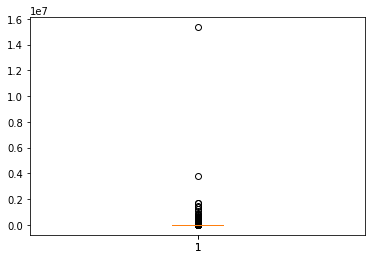

In [ ]:
plt.boxplot(df.followers_count)
plt.boxplot(df.statuses_count)

In [ ]:
df.followers_count.sort_values(ascending=False)
df.statuses_count.sort_values(ascending=False)

7822     1710193
13078    1694636
11489    1353113
7540      810571
6044      742270
          ...   
2314          17
9658          14
10794         11
10872          8
11892          4
Name: statuses_count, Length: 10996, dtype: int64

Delete outliers

In [ ]:
df.drop(labels = [4434,8429,7822,13078,11489],inplace=True)

## Feature extraction

Extract account age in days

In [ ]:
lista = [];
for idx, row in df.iterrows():
  lista.append(datetime.datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S%z"))
max(lista)

datetime.datetime(2019, 5, 19, 8, 13, 57, tzinfo=datetime.timezone.utc)

With max(lista) == datetime.datetime(2019, 5, 19, 8, 18, 38, tzinfo=datetime.timezone.utc) and we sum 12 days

In [ ]:
new = datetime.datetime(2019, 6, 1, 0, 0, 0, tzinfo=datetime.timezone.utc);

Parse created at into profile_age

In [ ]:
profile_age = []
for idx, row in df.iterrows():
  diff = new-datetime.datetime.strptime(row.created_at,"%Y-%m-%d %H:%M:%S%z");
  age = diff.days+diff.seconds/(24*60*60);
  profile_age.append(age)

df.drop(columns="created_at",inplace=True);
df["profile_age"] = profile_age;

Count acttivity variables + friends ratio

In [ ]:
statuses_age_rate = [];
favourites_age_rate = [];
friends_rate = [];
for idx, row in df.iterrows():
  statuses_age_rate.append(row.statuses_count/row.profile_age);
  favourites_age_rate.append(row.favourites_count/row.profile_age);
  if row.friends_count != 0:
    friends_rate.append(row.friends_count/(row.followers_count+row.friends_count));
  else: friends_rate.append(0);

df["statuses_age_rate"] = statuses_age_rate;
df["favourites_age_rate"] = favourites_age_rate;
df["friends_rate"] = friends_rate; #0 human, 1 bot

# Coding binary variables


In [ ]:
df.replace({False: 0, True: 1}, inplace=True);

Check profile_use_background_image balance

In [ ]:
df.profile_use_background_image.value_counts()
df.category[df.profile_use_background_image == 1].value_counts()

1    5292
0    4687
Name: category, dtype: int64

# Correlation matrix

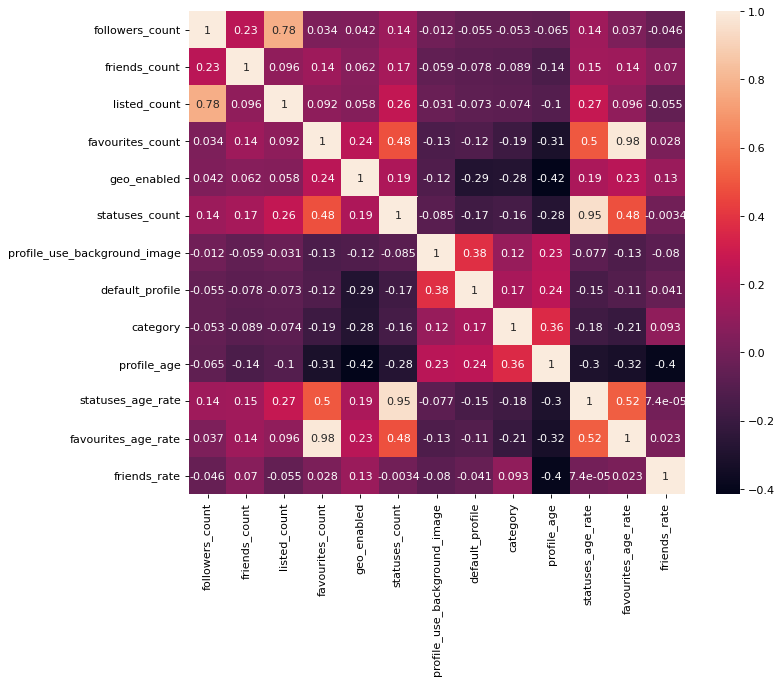

In [ ]:
corrMatrix = df.corr()
figure(figsize=(10, 8), dpi=80)
sn.heatmap(corrMatrix, annot=True)
plt.show()

Save dataset

In [ ]:
df.to_csv('botNoBot2018_preprocessed.csv',index=False)
from google.colab import files
files.download('botNoBot2018_preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>